# Numerics for two receptor model 

## Dependencies

In [13]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib as mpl
import pandas as pd

## PARAMETER INITIALISATION (from Suppl. Table 2 & 3)

In [14]:
# free ligand production rate at source in nM/s
J = 0.3 
#receptor production rate in nM.um/s
JR = 2.6e-3 
#transfer coefficient to heamolymph ( in s^{-1})
kappa_H = 0.075 
# area fraction of intercellular space at tissue haemo. interface
phi = 0.012 
# height and width of tissue in um
H = 53.; w=100 
# half-length of source and length of tissue
l = 26/2.; L = 116 
#number of points on the grid [l,L]
Ngrid = 200 
#diffusion coefficient of free ligand, here for GFP dimer (in um^2/s)
D0 = 21./(2.**(1./3.)); 
#diffusion constant of GPI-anchored receptor (in um^2/s)
Dr = 0.1
#typical width of intercellular space (in um)
h = 0.02
#geometric factor for increase in binding rate due to proximity
g = 100.

# parameters for high-affinity receptors (SR)
konA = 7.7*10**-4;
koffA = 1.7*10**-4;

# parameters for low affinity receptors (NR)
konB = 2*10**-3;
koffB = 5*10**-2;

#degradation rate of signalling configuration
kint_signal = 2.1*10**-3
#degradation rate of non-signalling configurations 
kint = JR / 100.; #2.6*10**-5;
# rescaled degradation rate in hemolymph (in s^{-1})
KH_bar = 0.01 
# volume of hemolymph
Vh = 1e8 
# inferred from KH_bar for given Vh 
#(specific choice of Vh only affects time to st.st.)
KH = KH_bar * (2*phi*w*H*L) / Vh 
# time-rescaling factor to speed up hemolymph dynamics 
#(does not affect steady state)
effective_vh_scaling = 100 
#suppression factor for permeability of NR into haemolymph
psi = 0

## Discrete operators and lattice specifications

In [15]:
#discrete laplacian operator to use for diffusion terms
discr_lap = np.zeros((Ngrid,Ngrid))
discr_lap += np.diag(np.full(Ngrid,-2))
discr_lap[0,0]=-1
discr_lap[-1,-1]=-1
discr_lap += np.diag(np.full(Ngrid-1,1),k=1)
discr_lap += np.diag(np.full(Ngrid-1,1),k=-1)


#spatial coordinates of integration intervals
xcoord = np.linspace(0, L+l, Ngrid) - l; 
dx = xcoord[1]-xcoord[0]
xcoord_vels = xcoord * np.heaviside(xcoord,0)
indicator_source = 1 - np.heaviside(xcoord,0)
production_array = np.full(len(xcoord),1)

## Model dynamics (function definitions) - data generation and plotting

In [16]:
def odefunction(y,t,jrB,jrA,j_vec,hnd,psi):
    
    ''' This function defined the dynamics of the model.
    It it fed into scipy.integrate to generate data. 
     
    Arguments:
    jrB = NR production rate
    jrA = SR production rate
    j_vec = ligand production rate of different discretised sections of tissue 
    hnd = can be used to prevent formation of SR-NR complex (if set to zero)
    psi = can be tuned to control NR leakage (no leakage if  psi=0)
    '''
    
    # retrieve distinct concentrations from full state vector
    c = y[:Ngrid]
    nf_A = y[Ngrid:2*Ngrid]
    nb_A = y[2*Ngrid:3*Ngrid]
    nb_AA = y[3*Ngrid:4*Ngrid]
    nf_B = y[4*Ngrid:5*Ngrid]
    nb_B = y[5*Ngrid:6*Ngrid]
    nb_BB = y[6*Ngrid:7*Ngrid]
    nb_AB = y[7*Ngrid:8*Ngrid]
    c_hae = y[-1]
    
    # terms that repeat - only calculate once for convenience
    #Suppl.Eq. 76
    r_0_A = 2 * konA * nf_A * c - koffA * nb_A 
    #Suppl.Eq. 77
    r_0_B = 2 * konB * nf_B * c - koffB * nb_B 
    #Suppl.Eq. 78
    r_A_AA = g * konA * nb_A * nf_A - koffA * nb_AA 
    #Suppl.Eq. 79
    r_B_BB = g * konB * nb_B * nf_B - koffB * nb_BB 
    #Suppl.Eq. 80
    r_A_AB = hnd * (g * konB * nb_A * nf_B - koffB * nb_AB) 
    #Suppl.Eq. 81
    r_B_AB = hnd * (g * konA * nf_A * nb_B - koffA * nb_AB) 
    
    # increments of individual concentrations as defined in the model
    #Suppl.Eq. 67
    c_dt = (j_vec - kappa_H * (c-c_hae) 
            + D0/(dx**2) * discr_lap.dot(c) 
            - r_0_A / h - r_0_B / h )
    #Suppl.Eq. 69
    nf_A_dt = -r_0_A - r_A_AA - kint * nf_A - r_B_AB  + jrA * production_array 
    #Suppl.Eq. 70   
    nb_A_dt = r_0_A - r_A_AA - r_A_AB  - kint * nb_A 
    #Suppl.Eq. 71  
    nb_AA_dt = r_A_AA - kint_signal * nb_AA                          
    #Suppl.Eq. 72
    nf_B_dt = -r_0_B - kint * nf_B + jrB - r_B_BB - r_A_AB + Dr/(dx**2)*discr_lap.dot(nf_B) 
    #Suppl.Eq. 73
    nb_B_dt = r_0_B - r_B_BB - r_B_AB  - kint * nb_B + Dr/(dx**2)*discr_lap.dot(nb_B) 
    #Suppl.Eq. 74
    nb_BB_dt = r_B_BB - kint * nb_BB + Dr/(dx**2)*discr_lap.dot(nb_BB) 
    #Suppl.Eq. 75
    nb_AB_dt = r_A_AB + r_B_AB  - kint * nb_AB
    #Suppl.Eq. 68
    c_hae_dt = effective_vh_scaling * KH * ( kappa_H/KH_bar *  np.mean(c - c_hae) - c_hae ) 
    
    update_array = np.zeros(8*Ngrid + 1)
    update_array[:Ngrid] = c_dt
    update_array[Ngrid:2*Ngrid] = nf_A_dt
    update_array[2*Ngrid:3*Ngrid] = nb_A_dt
    update_array[3*Ngrid:4*Ngrid] = nb_AA_dt
    update_array[4*Ngrid:5*Ngrid] = nf_B_dt
    update_array[5*Ngrid:6*Ngrid] = nb_B_dt
    update_array[6*Ngrid:7*Ngrid] = nb_BB_dt
    update_array[7*Ngrid:8*Ngrid] = nb_AB_dt
    update_array[-1] = c_hae_dt
    
    return update_array


def single_run(jrB,jrA,j,hnd,psi,meas_time):    
    ''' This function returns a single realisation of the model evolved from 
    zero ligand initial condition to its (steady) state after meas_time/3600 h.
    The function also generated some concentration plots to check outcome.
    Returns the concentration profile of SR-SR signalling complexes.
    
     Arguments:
    jrB = NR production rate
    jrA = SR production rate
    j = ligand production rate
    hnd = can be used to prevent formation of SR-NR complex (if set to zero)
    psi = can be tuned to control NR leakage (no leakage if  psi=0)
    meas_time = total simulation time (in seconds)'''
    
    t_steps = 100 
    t = np.linspace(0, meas_time,  t_steps)  

    y0=np.zeros((8*Ngrid+1))
    y0[4*Ngrid:5*Ngrid]=np.full(Ngrid,jrB/kint);
    j_vec = np.zeros(Ngrid); j_vec[:int(l/dx)] = np.full(int(l/dx),j)
    
    tol=10**-6
    X, infodict = integrate.odeint(odefunction,
                                   y0,
                                   t,
                                   args=(jrB,jrA,j_vec,hnd,psi),
                                   full_output=True,rtol=tol, atol=tol)
    infodict['message']
    
    c = X[-1, :Ngrid]
    nf_A = X[-1, Ngrid:2*Ngrid]
    nb_A = X[-1, 2*Ngrid:3*Ngrid]
    nb_AA = X[-1, 3*Ngrid:4*Ngrid]
    #nf_B = X[-1, 4*Ngrid:5*Ngrid]
    nb_B = X[-1, 5*Ngrid:6*Ngrid]
    nb_BB = X[-1, 6*Ngrid:7*Ngrid]
    nb_AB = X[-1, 7*Ngrid:8*Ngrid]
    c_hae = X[:, -1]
    
    nb_AA_relaxation = X[:, 3*Ngrid:4*Ngrid][:, 0:Ngrid:20]

    # plot of signalling complex concentration gradient
    plt.figure(1)
    plt.plot(xcoord, nb_AA)
    plt.vlines(0, 0, np.max(nb_AA), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('SR-GFP-SR concentration [nM $\mu$m]')
    
    # plot of once-bound SR concentration
    plt.figure(2)
    plt.plot(xcoord,nb_A)
    plt.vlines(0, 0, np.max(nb_A), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('SR-GFP concentration [nM $\mu$m]')
    
    # plot of twice-bound NR concentration
    plt.figure(3)
    plt.plot(xcoord,nb_BB)
    plt.vlines(0, 0, np.max(nb_BB), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('NR-GFP-NR concentration [nM $\mu$m]')
    
    # plot of once-bound NR concentration
    plt.figure(4)
    plt.plot(xcoord, nb_B)
    plt.vlines(0, 0, np.max(nb_B), linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('NR-GFP concentration [nM $\mu$m]')
    
    # plot of NR-GFP-SR concentration
    plt.figure(5)
    plt.plot(xcoord,nb_AB)
    plt.vlines(0,0,np.max(nb_AB),linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('NR-GFP-SR concentration [nM $\mu$m]')
    
    # plot of unbound SR concentration
    plt.figure(6)
    plt.plot(xcoord, nf_A)
    plt.vlines(0,0,np.max(nf_A),linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('free SR concentration [nM $\mu$m]')
    
    
    # plot of free ligand concentration
    plt.figure(7)
    plt.plot(xcoord,c)
    plt.vlines(0,0,np.max(c),linestyle='dashed')
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('Free GFP concentration [nM]')
    
    # time curves of signalling intensity at representative positions
    plt.figure(8)
    for k in range(10):
        plt.plot(np.arange(0,t_steps,1),nb_AA_relaxation[:,k])
    plt.xlabel('Time elapsed from initialisation [a.u.]')
    plt.ylabel('SR-GFP-SR concentration')
    
    # fluorescence of bound vs free GFP
    plt.figure(9)
    fluor_tot = (nb_A + nb_AA + nb_B + nb_BB + nb_AB)/h
    plt.semilogy(xcoord,fluor_tot)
    plt.semilogy(xcoord,c)
    plt.xlabel('Distance from source [$\mu$m]')
    plt.ylabel('Bound vs free GFP concentration [nM]')
    
    
    return nb_AA

def values_for_phase(high_t,low_t,jrB,jrA,j,hnd,psi,meas_time):
    '''
    Function used to populate phase diagrams in Figure 4 in a parallel fashion.
    Returns array([high-level target range, low-level target range, backflow tail level])
    The first two outputs are Nan if the range is zero or infinite.
    Final output is a flag to detect rare cases where high-target is crossed twice (strip activation)
    '''
    

    outputs = np.array([float(-1000),float(1000),float('nan'),float(0.0)])
    nbhh_profile = single_run(jrB,jrA,j,hnd,psi,meas_time)
    
    for kk in range(len(nbhh_profile)):
        
        if nbhh_profile[-(kk+1)] > high_t:
            if kk == 0: #meaning lowest value is already larger than high level target
                outputs[0] = 1000
                break 
            elif (xcoord[-(kk+1)+1] + xcoord[-(kk+1)])/2. < 0.: #meaning the condition is satisfied inside the source
                break #keep -1000 as output
        else:
                outputs[0] = (xcoord[-(kk+1)+1] + xcoord[-(kk+1)])/2.
                break
    
    for nn in range(len(nbhh_profile)-1):
        if nbhh_profile[-(nn+1)] > high_t and nbhh_profile[-(nn+2)] < high_t:
            outputs[3] = 1.0
    
    for ll in range(len(nbhh_profile)):
        
        if nbhh_profile[-(ll+1)] > low_t:
            if ll == 0: #meaning the lowest value is already larger than low-level target (activated everywhere)
                break #i.e. keep 1000 as output
            else:
                outputs[1] = (xcoord[-(ll+1)+1] + xcoord[-(ll+1)])/2.
                break
        
    outputs[2] = nbhh_profile[-1]
    with open("param_map.txt","a") as myfile:
    	myfile.write( str(jrA)+' '+str(jrB)+' '+str(outputs[0])+' '+str(outputs[1])+' '+str( outputs[2])+' '+str(outputs[3])+'\n' )
    return 

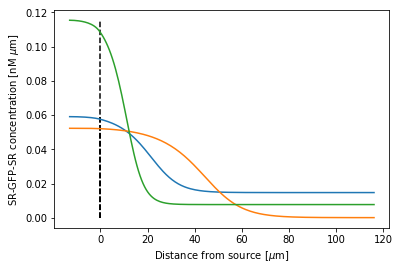

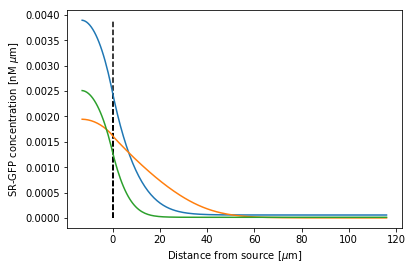

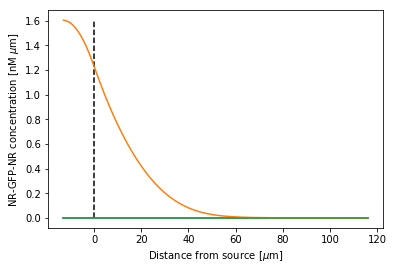

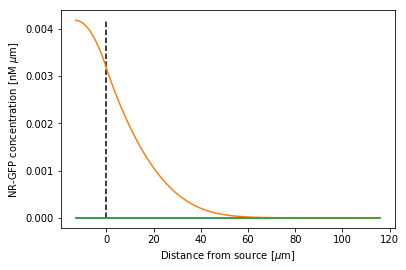

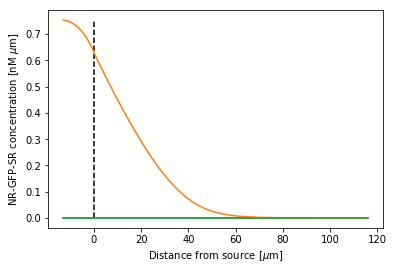

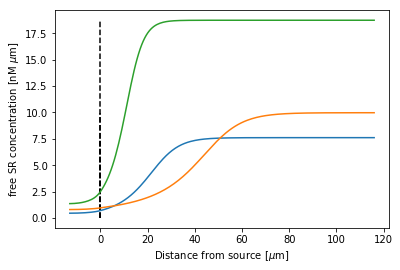

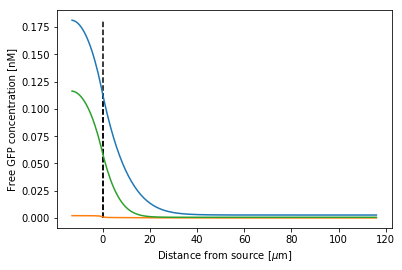

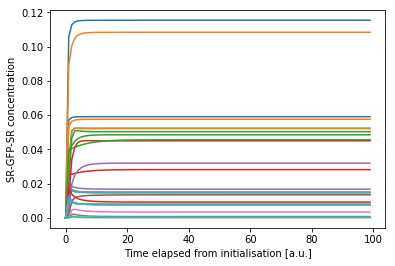

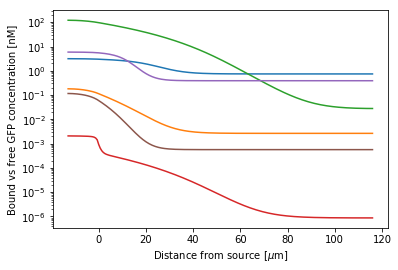

In [17]:
#test run, example of gradient extension with diffusing NR
single_run(jrB=0*JR, jrA=JR/10., j=0.1*J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=1*JR, jrA=JR/10., j=0.1*J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=0*JR, jrA=2*JR/10., j=0.1*J, hnd=1, psi=0, meas_time=200*3600);

# Code to generate figures in manuscript
## Fig 5B

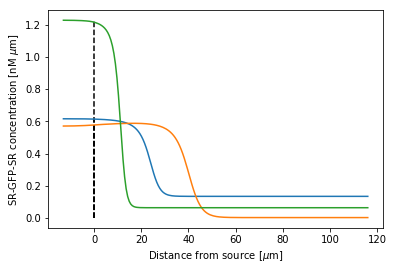

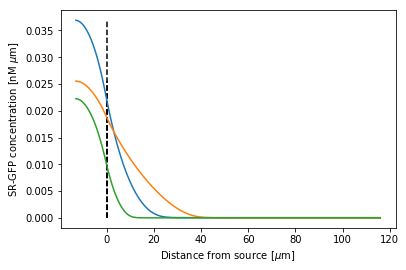

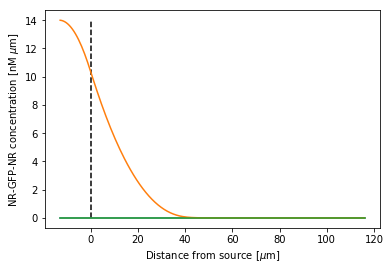

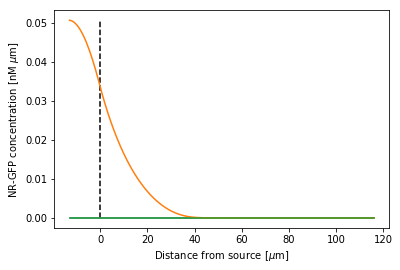

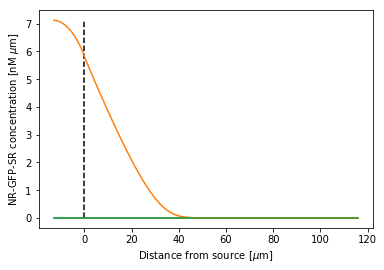

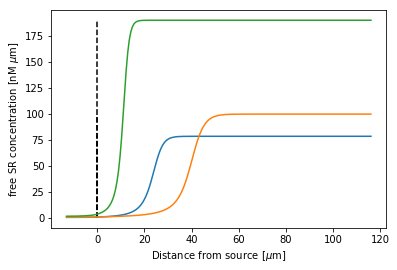

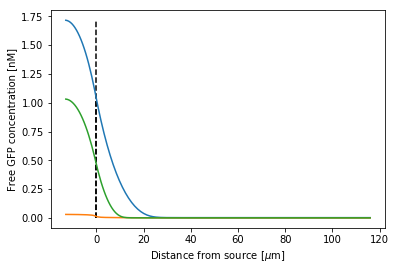

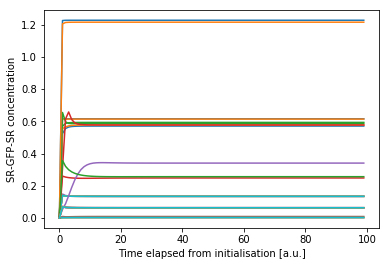

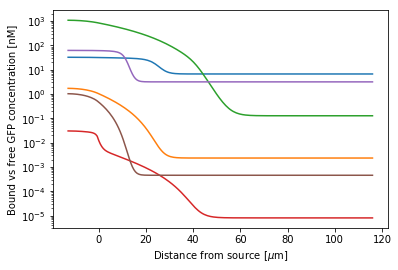

In [ ]:
Dr = 0.1
single_run(jrB=0*JR, jrA=JR, j=J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=1*JR, jrA=JR, j=J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=0*JR, jrA=2*JR, j=J, hnd=1, psi=0, meas_time=200*3600);

## Fig S13B

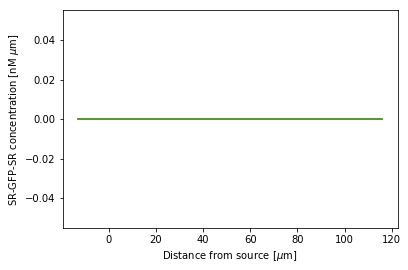

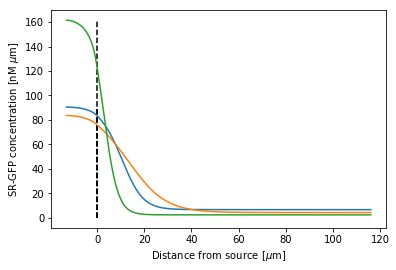

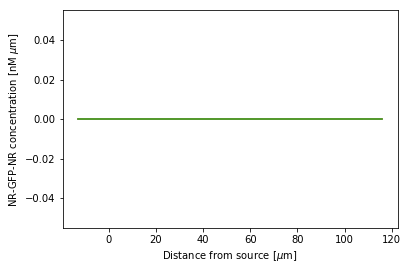

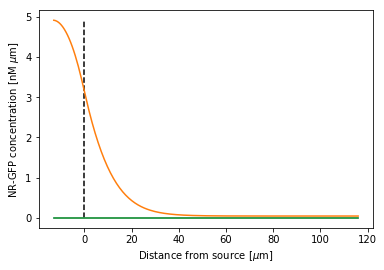

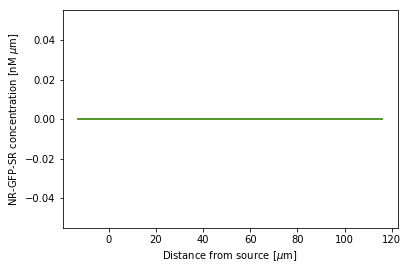

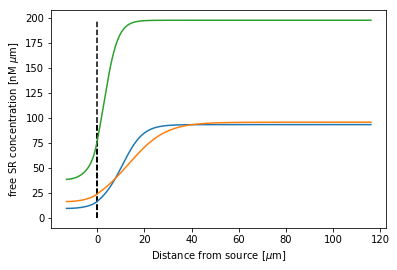

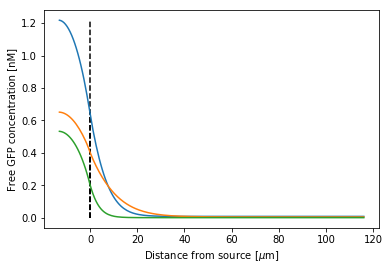

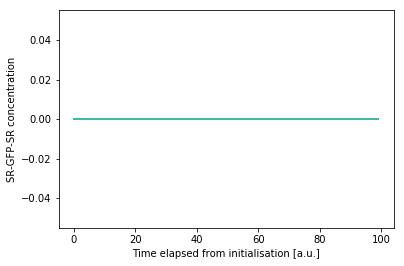

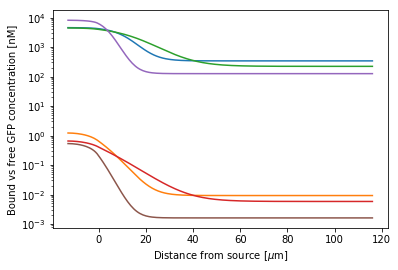

In [ ]:
''' Fig S13 B'''
Dr = 0.1; g=0; hnd=0;
single_run(jrB=0*JR, jrA=JR, j=J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=1*JR, jrA=JR, j=J, hnd=1, psi=0, meas_time=200*3600);
single_run(jrB=0*JR, jrA=2*JR, j=J, hnd=1, psi=0, meas_time=200*3600);

## Fig5C

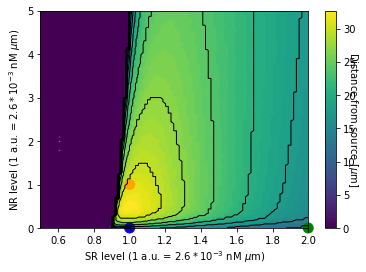

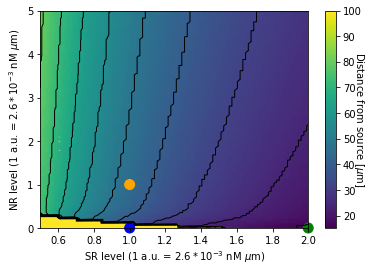

In [21]:
''' Fig 5 C,D'''
import pandas as pd
data = pd.read_csv('param_map_steady_F5C_dxFIX.txt', header = None, sep=" ")
plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[2],
            vmin=0,
            s=10)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,5))
cbar.set_label('Distance from source [$\mu$m]', rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[2]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],[0,1,0],c=['blue','orange','green'],s=100,clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[3],
            vmax=100,
            s=10)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,5))
cbar.set_label('Distance from source [$\mu$m]',
               rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[3]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],
            [0,1,0],
            c=['blue','orange','green'],
            s=100,
            clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

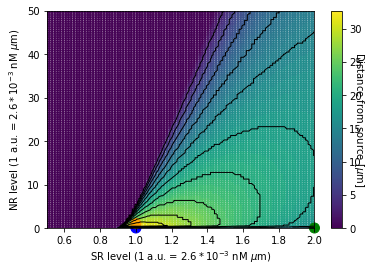

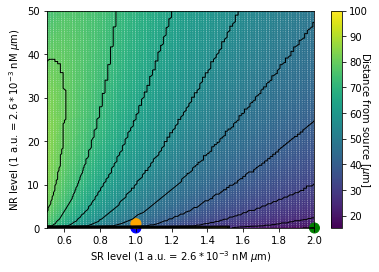

In [22]:
''' replot phase diagrams as in Fig 5 C,D with extended NR range'''
import pandas as pd
data = pd.read_csv('param_map_steady_F5C_extendedNR_dxFIX.txt', header = None, sep=" ")
plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[2],
            vmin=0,
            s=4)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,50))
cbar.set_label('Distance from source [$\mu$m]', rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[2]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],[0,1,0],c=['blue','orange','green'],s=100,clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

plt.figure()
plt.scatter(data[0]/JR,
            data[1]/JR,
            c=data[3],
            vmax=100,
            s=4)
cbar=plt.colorbar();
plt.xlim((0.5,2));
plt.ylim((0,50))
cbar.set_label('Distance from source [$\mu$m]',
               rotation=270)
plt.tricontour(data[0]/JR,
               data[1]/JR,
               (data[3]+1000)%1000,
               10,
               linewidths=1,
               colors='k',
               vmin=0,
               vmax=100)
plt.scatter([1,1,2],
            [0,1,0],
            c=['blue','orange','green'],
            s=100,
            clip_on=False)
plt.xlabel('SR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');
plt.ylabel('NR level (1 a.u. = $2.6 * 10^{-3}$ nM $\mu$m)');

The data for the above contour plots was generated by running the following script on the Crick computing cluster. 

    %%bash
    #!/bin/bash
    #SBATCH -n 1 #number of processes
    #SBATCH --job-name=phaseF5C
    #SBATCH --time=30:00:00 #max runtime
    #SBATCH --array=1-9801 #number of parallel realisations
    param_store=$./parameter_list.txt

    ml Anaconda3

    jrV=$(cat $param_store | awk -v var=$SLURM_ARRAY_TASK_ID 'NR==var {print $1}')
    jrL=$(cat $param_store | awk -v var=$SLURM_ARRAY_TASK_ID 'NR==var {print $2}')    # Get second argument

    srun -n 1 -u launch_script.py  " $jrL "  " $jrV "

    echo "done"

with parameter_list.txt being a two-column table of receptor production generated via 

    #generate parameter table for phase plots S5C
    import numpy as np

    jrV_steps= np.linspace(0.5,2,99)
    jrL_steps=np.linspace(0,5,99)
    Args=[]
    for i in range(len(jrV_steps)) :
        for j1 in range(len(jrL_steps)):
            Args.append((jrV_steps[i],jrL_steps[j1]))
            test=np.array(Args);
    np.savetxt('parameter_list.txt', test, delimiter=' ',fmt='%1.6f')

and launch_script.py reading

    #!/usr/bin/env python2
    from SUBMISSION_spilling_source_degr_full_micro_2receptors import *
    import sys

    high_t = 0.55
    low_t = 0.09

    jrL = 2.6e-3 * float(sys.argv[1])
    jrV = 2.6e-3 * float(sys.argv[2])

    values_for_phase(high_t,low_t,jrL,jrV,j,hnd,k_detL,k_reaL,psi,meas_time)


## Fig S13D

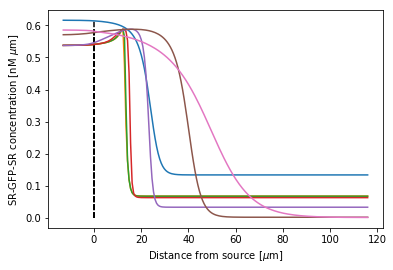

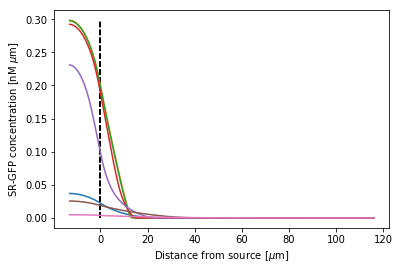

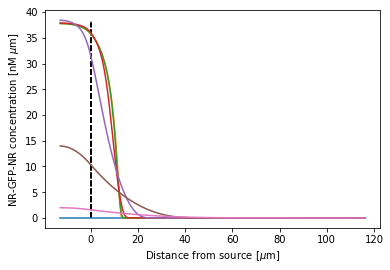

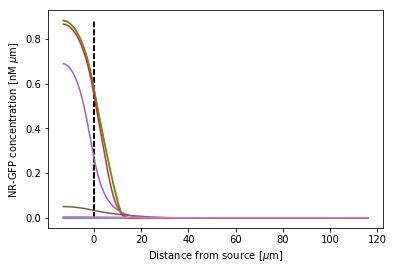

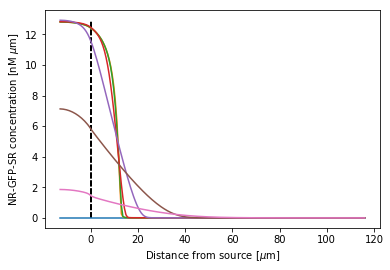

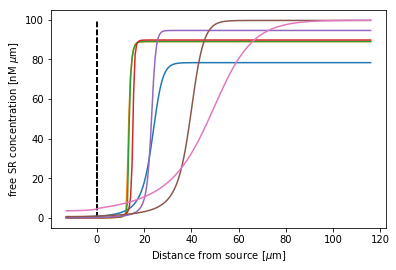

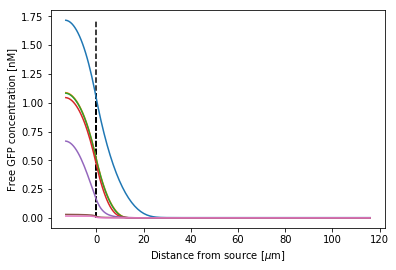

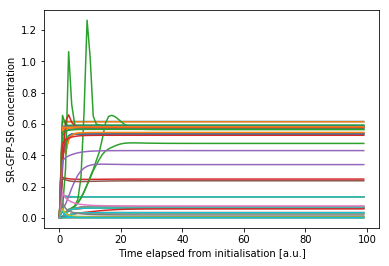

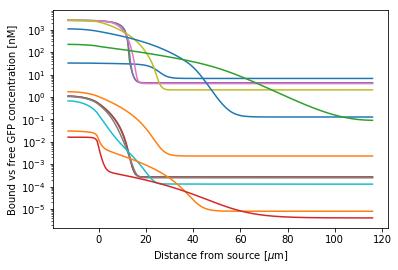

In [23]:
Dr = 0.1;
g = 100.;
hnd = 1;
single_run(jrB=0*JR,
           jrA=JR,
           j=J,
           hnd=1,
           psi=0,
           meas_time=200*3600);
for Dr in [0.,0.0001,0.001,0.01,0.1,1]:
    single_run(jrB=JR,
               jrA=JR,
               j=J,
               hnd=1,
               psi=0,
               meas_time=200*3600);

## Fig S13E

Calculate length scale for model with two receptors, based on Eq. 58 in the supplementary.

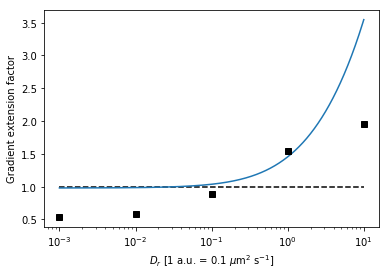

In [24]:
def S_extension(sigma):
    """ return l/l0 where l is the length scale of the gradient
    l0 is the reference length scale for jrb=0 (no second receptor)
    Dr is varied relative to 0.1um^2/s"""
    #receptor production, set equal for the two receptors
    jrB = JR
    jrA = JR
    #effective degradation rate for A and B
    kra = (konA * jrA) / (h * (kint_signal + koffA))
    krb = (konB * jrB) / (h * (kint + koffB))
    #sigma is factor that changes Dr relative to 0.1um^2/s
    #Drt is Dr/(kb+koffb)
    Drt = 0.1 * sigma / (kint + koffB)
    #coefficients in polynomial equation Eq. 58, for S=l/l0
    #with l0 = sqrt(D0/(kra+kappa_H))
    C1 = (kra  + krb  + kappa_H) * D0 **2 / (kra + kappa_H)**2
    C2 = (D0 + Drt * (kra + krb * (kint + koffB) / kint  + kappa_H)) * D0 / (kra + kappa_H)
    C3 = D0 * Drt
    #calculate the factor S
    return np.sqrt((C2 + np.sqrt(C2**2 - 4*C1*C3))/(2*C1))

plt.figure()
xs = [10**x for x in np.linspace(-3,1,10000)]
ys = np.array([S_extension(x) for x in xs])
plt.semilogx(xs,ys)
plt.hlines(1,
           1e-3,
           10,
           color='k',
           linestyle='dashed')
# plot values from full simulation
plt.plot([0.001,
          0.01,
          0.1,
          1,
          10],
         [14.2 / 26.7,
          15.6 / 26.7,
          23.6  /26.7,
          41 / 26.7,
          52.2 / 26.7],
         'ks')
plt.xlabel('$D_r$ [1 a.u. = 0.1 $\mu$m$^2$ s$^{-1}$]')
plt.ylabel('Gradient extension factor');

## Fig S5G

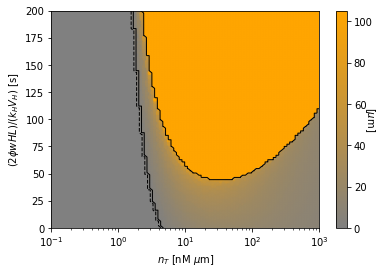

In [25]:
def discrim(x):
    if x < -900:
        return 'nan' 
    elif x > 900:
        return 'nan'
    else:
        return x

def discrim1(x):
    if x == -1000:
        return 'grey' 
    elif x == 1000:
        return 'grey'
    else:
        return 'grey'

def discrim2(x):
    if x == -1000:
        return 'grey' 
    elif x == 1000:
        return 'orange'
    else:
        return 'grey'

cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', 
                                             [(0,    'grey'),
                                              (1,    'Orange')], N=126)

plt.figure()
data = pd.read_csv('param_map_fast_dxFIX.txt',
                   header = None,
                   sep=" ")
plt.scatter(data[0]/kint,
            1./(data[1]*Vh/(2*phi*w*H*L)),
            c=[discrim1(x) for x in data[2]],
            s=10,
            vmin=-1100,
            vmax=0)
plt.scatter(data[0]/kint,1/(data[1]*Vh/(2*phi*w*H*L)),c=[discrim2(x) for x in data[2]],s=10,vmin=0,vmax=1000)
plt.scatter(data[0]/kint,1/(data[1]*Vh/(2*phi*w*H*L)),c=[discrim(x) for x in data[2]],s=10,vmin=0,cmap=cmap)

cbar = plt.colorbar(); cbar.set_label('[$\mu$m]', rotation=270)
plt.semilogx(); plt.xlabel('$n_T$ [nM $\mu$m]'); plt.ylabel('$(2 \phi w H L)/(k_H V_H)$ [s]')
plt.xlim((0.1,1000));
plt.ylim((0,200));
plt.semilogx()

plt.tricontour(data[0]/kint,
               1./(data[1]*Vh/(2*phi*w*H*L)),
               data[2],
               2,
               colors='k',
               vmax=1000,
               linewidths=1)

The data for this plot was generated with similar scripts to those available above for Fig. 5C, which were run on the Crick computing cluster. Specific parameters of the model (namely and g, m, D, kint_signal) where modified with respect to the above values to account for the dimer nature of the ligand, as explained in the figure legend and the discussed in the Supplementary Material.